In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir

%matplotlib inline
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

In [3]:
from tqdm.notebook import tqdm

In [4]:
DATA_DIR = join("datasets", "lefebvre_2017_nhb")

In [5]:
def read_process_mat(matfile, experiment):
    """This function reads a .mat file from the Lefebvre data
    and transforms it into a pandas DataFrame.
    
    Args:
        matfile (str): Path to the .mat file.
        experiment (int): One of [1, 2]. Indicate the experiment, from which the data file is.
            Background: The data files differ in their columns, so we have to be explicit about it.
    
    Returns:
        pandas.DataFrame: Formatted data.
    """
    # Extract subject ID
    subject = int(re.findall("_\d+.mat", matfile)[0][1:-4])

    # Read .mat file and convert to DataFrame with named columns
    if experiment == 1:
        columns = ["_", "trial", "s", "_", "_", "_", "a", "r", "_"]
    elif experiment == 2:
        columns = ["_", "trial", "s", "_", "a", "_", "_", "r"]
    x = loadmat(matfile)
    df = pd.DataFrame(x["data"], columns=columns)

    # Reformat variables
    df["subject"] = subject
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["block"] = 0
    df["a"] = (df["a"] / 2 + 0.5).astype(
        np.int32
    )  # Transform action from [-1, 1] to [0, 1]
    df["s"] = (df["s"] - 1).astype(
        np.int32
    )  # Transform states from [1, 2, 3, 4] to [0, 1, 2, 3]
    if experiment == 1:
        df["r"] = df["r"] / 2  # Transform rewards from [0, 1] to [0, 0.5]

    return df[["subject", "block", "trial", "s", "a", "r"]]


df = read_process_mat(join(DATA_DIR, "data_exp1", "exp1_4.mat"), experiment=1)
df.head()

,subject,block,trial,s,a,r
0,4,0,0,0,0,0.0
1,4,0,1,0,0,0.0
2,4,0,2,0,1,0.0
3,4,0,3,0,0,0.5
4,4,0,4,1,0,0.5


# Prepare estimation

In [6]:
task_vars = rl.task.TaskVars(n_trials=96, n_blocks=1, n_options=2, n_states=4)

In [7]:
# Initialize estimation variables

# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 100)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

# Experiment 1

In [8]:
# Initialize agent_vars (for initial Q values). Q_init was 0.25 in Experiment 1
agent_vars = rl.agent.AgentVars(Q_init=np.ones((4, 2)) * 0.25)

matfiles = [
    file for file in listdir(join(DATA_DIR, "data_exp1")) if file.endswith(".mat")
]

results_exp1 = []

for matfile in tqdm(matfiles):

    # Subject DataFrame
    filename = join(DATA_DIR, "data_exp1", matfile)
    df_s = read_process_mat(filename, experiment=1)
    subject = df_s["subject"][0]

    # Now we can estimate the maximum likelihood parameters
    result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

    # Save results to DataFrame
    result_df = pd.DataFrame(
        dict(
            subject=subject,
            nll=result[0],
            bic=result[1],
            alpha_pos=result[2][0],
            alpha_neg=result[2][1],
            beta=result[2][2],
        ),
        index=[subject],
    )
    results_exp1.append(result_df)

results_exp1 = pd.concat(results_exp1).sort_values("subject")

In [9]:
results_exp1["1/beta"] = 1.0 / results_exp1["beta"]

In [10]:
results_exp1.head()

,subject,nll,bic,alpha_pos,alpha_neg,beta,1/beta
1,1,54.705569,123.104182,1.000000,0.733966,4.388796,0.227853
2,2,22.854502,59.402048,0.044734,0.035604,100.000000,0.010000
3,3,39.595961,92.884967,0.051940,0.014310,57.950836,0.017256
4,4,49.898995,113.491035,0.648846,0.051446,8.298981,0.120497
5,5,48.736446,111.165936,0.220194,0.000000,9.063291,0.110335


In [11]:
results_exp1[["nll", "bic", "alpha_pos", "alpha_neg", "1/beta"]].describe().round(2)

,nll,bic,alpha_pos,alpha_neg,1/beta
count,50.00,50.00,50.00,50.00,50.00
mean,40.07,93.82,0.29,0.15,0.09
std,16.47,32.95,0.32,0.28,0.13
min,7.24,28.17,0.00,0.00,0.01
25%,24.72,63.13,0.07,0.00,0.01
50%,40.75,95.19,0.16,0.03,0.06
75%,53.39,120.47,0.43,0.10,0.12
max,65.32,144.33,1.00,1.00,0.80


These values are similar to the ones reported in the paper. They are not identical, I suspect that the optimization procedure introduced some variation, but that is just a guess. The $\beta$ parameter in particular is noticeably larger here. Maybe there are also differences in parameterization (e.g., estimation of $\frac{1}{\beta}$ instead of $\beta$).

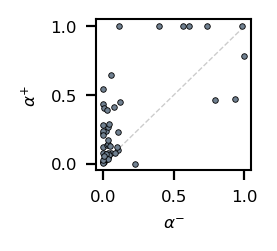

In [12]:
fig, ax = plt.subplots(figsize=(1, 1), dpi=200)
ax.plot(results_exp1["alpha_neg"], results_exp1["alpha_pos"], "o", markeredgewidth=0.3)
ax.set_xlabel(r"$\alpha^{-}$")
ax.set_ylabel(r"$\alpha^{+}$")
ax.plot([0, 1], [0, 1], "--k", alpha=0.2, zorder=-1, lw=0.5);

# Experiment 2

In [13]:
# Q_init = 0 in Experiment 2
agent_vars = rl.agent.AgentVars(Q_init=np.zeros((4, 2)))

matfiles = [
    file for file in listdir(join(DATA_DIR, "data_exp2")) if file.endswith(".mat")
]

results_exp2 = []

for matfile in tqdm(matfiles):

    # Subject DataFrame
    filename = join(DATA_DIR, "data_exp2", matfile)
    df_s = read_process_mat(filename, experiment=2)
    subject = df_s["subject"][0]

    # Now we can estimate the maximum likelihood parameters
    result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

    # Save results to DataFrame
    result_df = pd.DataFrame(
        dict(
            subject=subject,
            nll=result[0],
            bic=result[1],
            alpha_pos=result[2][0],
            alpha_neg=result[2][1],
            beta=result[2][2],
        ),
        index=[subject],
    )
    results_exp2.append(result_df)

results_exp2 = pd.concat(results_exp2).sort_values("subject")

In [14]:
results_exp2["1/beta"] = 1.0 / results_exp2["beta"]

In [15]:
results_exp2.head()

,subject,nll,bic,alpha_pos,alpha_neg,beta,1/beta
1,1,61.851416,137.395877,0.471154,0.000000,2.909889,0.343656
2,2,66.507367,146.707779,0.000443,0.000000,78.635495,0.012717
3,3,41.285232,96.263509,1.000000,0.556993,3.513865,0.284587
4,4,19.685311,53.063667,0.386173,0.209549,15.196190,0.065806
5,5,65.418768,144.530581,0.560498,1.000000,0.730092,1.369691


In [16]:
results_exp2[["nll", "bic", "alpha_pos", "alpha_neg", "1/beta"]].describe().round(2)

,nll,bic,alpha_pos,alpha_neg,1/beta
count,35.00,35.00,35.00,35.00,35.00
mean,39.10,91.90,0.39,0.11,0.20
std,17.27,34.54,0.34,0.21,0.26
min,11.04,35.77,0.00,0.00,0.01
25%,26.33,66.34,0.09,0.00,0.04
50%,38.79,91.26,0.25,0.03,0.13
75%,52.57,118.83,0.65,0.14,0.27
max,66.51,146.71,1.00,1.00,1.37


As for experiment 1, these estimates are similar to the ones reported in the paper, yet not identical. The largest deviation comes from the $\beta$ parameter.